In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Flatten
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.datasets import cifar10
import keras 

Using TensorFlow backend.


In [16]:
batch_size = 1024
original_dim = 32*32*3
img_rows, img_cols, img_channels = 32, 32, 3
latent_dim = 2
intermediate_dim = 100
epochs = 50
epsilon_std = 1.0

In [17]:
x = Input(shape=(original_dim,))
a = Reshape((img_rows, img_cols, img_channels))(x)
a = Conv2D(32, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Conv2D(64, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Conv2D(128, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Flatten()(a)
h = Dense(intermediate_dim, activation='relu')(a)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [19]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [20]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_fc = Dense(2048, activation='relu')
decoder_reshape = Reshape((128, 4, 4))
decoder_conv1 = Conv2DTranspose(64, 3)
decoder_bn1 = BatchNormalization()
decoder_activ1 = LeakyReLU()
decoder_conv2 = Conv2DTranspose(32, 3)
decoder_bn2 = BatchNormalization()
decoder_activ2 = LeakyReLU()
decoder_conv3 = Conv2DTranspose(1, 3)
decoder_flatten = Flatten()
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
a = decoder_fc(h_decoded)
a = decoder_reshape(a)
a = decoder_conv1(a)
a = decoder_bn1(a)
a = decoder_activ1(a)
a = decoder_conv2(a)
a = decoder_bn2(a)
a = decoder_activ2(a)
a = decoder_conv3(a)
a = decoder_flatten(a)
x_decoded_mean = decoder_mean(a)

In [21]:
# instantiate VAE model
vae = Model(x, x_decoded_mean)

In [22]:
# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [23]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 32)   896         reshape_3[0][0]                  
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 16, 16, 32)   128         conv2d_4[0][0]                   
____________________________________________________________________________________________

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_12 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_12.
  'be expecting any data to be passed to {0}.'.format(name))


In [24]:
# pip install tf-nightly

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14341247942317895896
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9423389149440914806
physical_device_desc: "device: XLA_CPU device"
]


In [12]:
# example of progressively loading images from file
from keras.preprocessing.image import ImageDataGenerator
# create generator
datagen = ImageDataGenerator()
# prepare an iterators for each dataset
data = datagen.flow_from_directory('/home/ec2-user/SageMaker/genre-64', class_mode='binary')
# confirm the iterator works
batchX, batchy = data.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 29960 images belonging to 3 classes.
Batch shape=(32, 256, 256, 3), min=0.000, max=255.000


In [13]:
src_img_path  = Path('/home/ec2-user/SageMaker/genre-64')

NameError: name 'Path' is not defined

In [ ]:
# This dictionary should be updated to hold the absolute number of images associated with each genre used during training
styles = {
    "portraits": 14981,
    "landscapes": 14971
}

styleNum = {
    "portraits": 0,
    "landscapes": 1
}
    
curPos = {
    "portraits": 0,
    "landscapes": 0
}

In [ ]:
testNums = {}
trainNums = {}

In [138]:
# Generate test set of images made up of 1/20 of the images (per genre)
for k, v in styles.items():
    # put a twentieth of paintings in here
    nums = range(v)
    random.shuffle(list(nums))
    testNums[k] = nums[0 : v // 20]
    trainNums[k] = nums[v // 20 :]

In [139]:
import random

In [140]:
trainNums

{'portraits': range(749, 14981), 'landscapes': range(748, 14971)}

In [141]:
from PIL import Image
from numpy import asarray
import os
# load the image
portrait_dir = os.path.join(src_img_path,'portraits')
landscapes_dir = os.path.join(src_img_path,'landscapes')

In [142]:
def data_mat(path):
    lst = []
    images = os.listdir(path)
    for image in images:
        try:
            img = Image.open(os.path.join(path,image))
            data = asarray(img)
            lst.append(data)
        except Exception:
            pass
    return lst

In [144]:
# portraits = data_mat(portrait_dir)
# landscapes = data_mat(landscapes_dir)

In [ ]:
train = portraits[:int(len(portraits)*0.8)] + landscapes[:int(len(landscapes)*0.8)]
test = portraits[int(len(portraits)*0.8):] + landscapes[int(len(landscapes)*0.8):]

In [84]:
for i in range(len(train)):
    train[i] = train[i].astype('float32') / 255.
    train[i] = train[i].reshape((len(train[i]), np.prod(train[i].shape[1:])))
for i in range(len(test)):
    test[i] = test[i].astype('float32') / 255.
    test[i] = test[i].reshape((len(test[i]), np.prod(test[i].shape[1:])))

In [88]:
x_train.shape

(60000, 784)

In [95]:
# pip install tensorflow_datasets

In [96]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [108]:
builder = tfds.ImageFolder('/home/ec2-user/SageMaker/wikiart_post')
# print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='train', shuffle_files=True)
# tfds.show_examples(ds, builder.info)

In [106]:
ds.load_data()

AttributeError: '_OptionsDataset' object has no attribute 'load_data'

In [71]:
print(train.shape,train[0].shape)

AttributeError: 'list' object has no attribute 'shape'

In [26]:
# train the VAE on CIFAR digits
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
print(x_train.shape,x_train[0].shape)
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape,x_train[0].shape)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(50000, 32, 32, 3) (32, 32, 3)
(50000, 3072) (3072,)


In [27]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

vae.save('vae.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 117s 2ms/step - loss: 2059.4693 - val_loss: 2123.0254
Epoch 2/50
50000/50000 [==============================] - 111s 2ms/step - loss: 1988.7817 - val_loss: 2120.9784
Epoch 3/50
50000/50000 [==============================] - 111s 2ms/step - loss: 1976.8518 - val_loss: 2116.3747
Epoch 4/50
50000/50000 [==============================] - 111s 2ms/step - loss: 1970.1688 - val_loss: 2106.5342
Epoch 5/50
50000/50000 [==============================] - 109s 2ms/step - loss: 1965.2882 - val_loss: 2093.7808
Epoch 6/50
50000/50000 [==============================] - 109s 2ms/step - loss: 1963.5592 - val_loss: 2073.9504
Epoch 7/50
50000/50000 [==============================] - 107s 2ms/step - loss: 1962.5047 - val_loss: 2049.9410
Epoch 8/50
50000/50000 [==============================] - 106s 2ms/step - loss: 1959.5899 - val_loss: 2022.2566
Epoch 9/50
50000/50000 [==============================

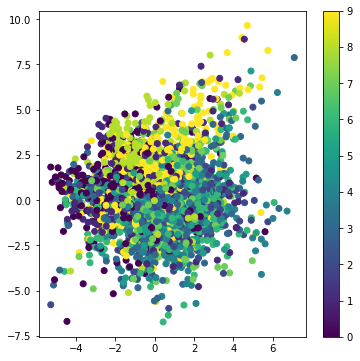

In [28]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

encoder.save('encoder.h5')

In [29]:
import json
with open('../src/encoded.json', 'w') as outfile:
    data = [[float(x), float(y), int(l)] for [x, y], l in zip(x_test_encoded, y_test)]
    json.dump(data, outfile)


FileNotFoundError: [Errno 2] No such file or directory: '../src/encoded.json'

In [31]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_a = decoder_fc(_h_decoded)
_a = decoder_reshape(_a)
_a = decoder_conv1(_a)
_a = decoder_bn1(_a)
_a = decoder_activ1(_a)
_a = decoder_conv2(_a)
_a = decoder_bn2(_a)
_a = decoder_activ2(_a)
_a = decoder_conv3(_a)
_a = decoder_flatten(_a)
_x_decoded_mean = decoder_mean(_a)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

generator.save('generator.h5')

ValueError: cannot reshape array of size 3072 into shape (32,32)

In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(generator, '../public/models/generatorjs')